# 01. 데이터셋 준비 및 탐색

### DTG(Digital Tacho Graph) data
- #### 텍스트 파일
- ######DT-202,6.01.810000000000000000011경기71바10081238100831###########000000100

텍스트파일 [:78]: 버스의 차량 정보


텍스트파일 [78:]: DTG 정보
- daily_dist
- total_dist
- event_date
- velocity(km/h)
- RPM
- break_on
- lat
- lon
- angle
- acc_x
- acc_y
- status

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
input_file = open('20210701_░ц▒т71╣┘1001.txt','r', encoding='cp949')
data = input_file.read()

In [6]:
data

'######DT-202,6.01.810000000000000000011경기71바10081238100831###########0000001000001413432107010720420000000000000000000000000000000-000.0-001.011000001413432107010720430000000000000000000000000000000-000.0-000.811000001413432107010720440000002400000000000000000000000-000.0-001.611000001413432107010720450000006910000000000000000000000+000.0-001.311000001413432107010720460000006150000000000000000000000-000.0-001.011000001413432107010720470000005250000000000000000000000-000.0-001.011000001413432107010720480000005110000000000000000000000+000.0-001.311000001413432107010720490000005270000000000000000000000+000.0-001.111000001413432107010720500000005350000000000000000000000-000.0-001.011000001413432107010720510000005400000000000000000000000-000.0-001.111000001413432107010720520000005430000000000000000000000+000.0-001.111000001413432107010720530000005160000000000000000000000-000.0-000.811000001413432107010720540000005440000000000000000000000-000.0-001.011000001413432107010720550000005350000000

In [7]:
# data[:78] # init_data
df = pd.DataFrame(columns=['daily_dist','total_dist','event_date','velocity(km/h)',
                           'RPM','break_on','lat','lon','angle','acc_x','acc_y','status'])

i=0
while True:
    line = data[76+i*68:144+i*68]
    if line=='':break
    df.loc[i]=[line[:4],line[4:11],line[11:25],line[25:28],line[28:32],
               line[32:33],line[33:42],line[42:51],line[51:54],line[54:60],line[60:66],line[66:68]]
    i+=1
    if i%20000==0:break

In [15]:
data[:78]

'######DT-202,6.01.810000000000000000011경기71바10081238100831###########000000100'

In [8]:
df.head()

daily_dist total_dist      event_date velocity(km/h)   RPM break_on   
0       0000    0141343  21070107204200            000  0000        0  \
1       0000    0141343  21070107204300            000  0000        0   
2       0000    0141343  21070107204400            000  0240        0   
3       0000    0141343  21070107204500            000  0691        0   
4       0000    0141343  21070107204600            000  0615        0   

         lat        lon angle   acc_x   acc_y status  
0  000000000  000000000   000  -000.0  -001.0     11  
1  000000000  000000000   000  -000.0  -000.8     11  
2  000000000  000000000   000  -000.0  -001.6     11  
3  000000000  000000000   000  +000.0  -001.3     11  
4  000000000  000000000   000  -000.0  -001.0     11

In [10]:
len(df) #2만개의 데이터

20000

## 속도, RPM, 가속도, anlge 도출

In [11]:
for i in df.index:
    try:df.loc[i,['velocity(km/h)','RPM','angle','acc_x','acc_y']].astype(float)
    except:df.loc[i]=(df.loc[i-1].astype(float)+df.loc[i+1].astype(float))/2

[]

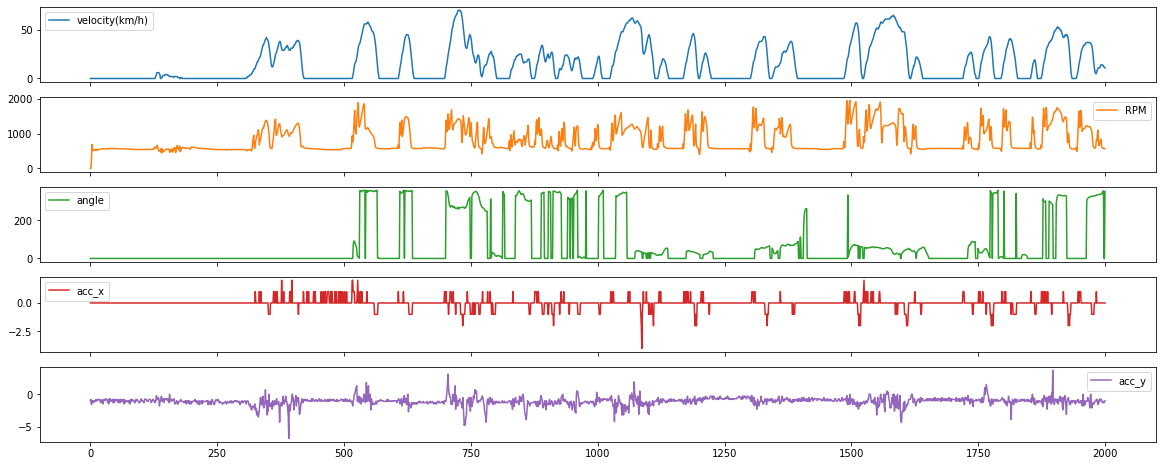

In [14]:
df_sample = df.loc[:2000]
df_sample[['velocity(km/h)','RPM','angle','acc_x','acc_y']].astype(float).plot(subplots=True, figsize=(20, 8))
plt.legend(loc='best')
plt.plot()

---

# 02. 급격한 주행 변화 감지 및 Driving Event 추출

### uLSIF(unconstrained least-squares importance fitting) : 두 개의 동일한 크기의 연속된 시간 데이터에서 두 분포의 밀도 비율 기반 차이를 사용하여 분포의 불일치도(dis-simmilairty) 계산
- #### 앞뒤 15초 간 데이터(속도, 가속도, 요레이트)의 밀도 비 차이를 이용한 불일치도 측정, 밀도비가 크게 변할수록 높은 점수
- #### 불일치도 상위 5% 지점을 급격한 주행 변화의 시발점으로 정의
- #### 시발점 이후 15초 간 운행을 위험 운전이라고 판단하여 해당 데이터 추출 -> Driving Event

#### (1) 가속도, 요레이트 데이터 생성

- 가속도: 1초간 속도의 차이
- 요레이트: 1초간 Angle의 차이

In [16]:
df['yaw_rate'] = None
df['acceleration'] = None
for idx1,idx2 in zip(df.index[:-1],df.index[1:]):
    yaw1,vel1 = df.loc[idx1,['angle','velocity(km/h)']]
    yaw2,vel2 = df.loc[idx2,['angle','velocity(km/h)']]
    df.loc[idx2,'yaw_rate'] = float(yaw2)-float(yaw1)
    df.loc[idx2,'acceleration'] = float(vel2)-float(vel1)

[]

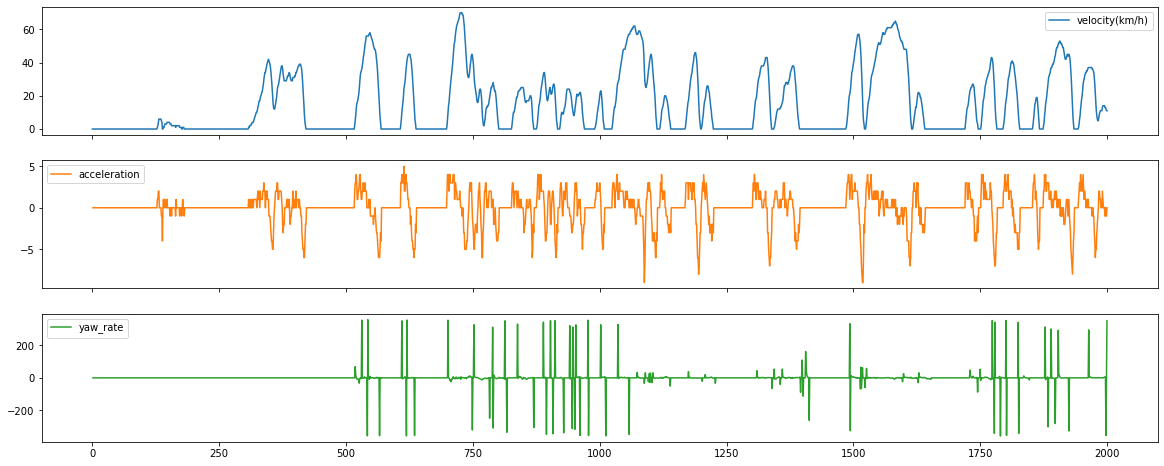

In [18]:
df_sample = df.loc[:2000]
df_sample[['velocity(km/h)','acceleration','yaw_rate']].astype(float).plot(subplots=True, figsize=(20, 8))
plt.legend(loc='best')
plt.plot()

#### (2) 불일치도 계산

uLSIF는 두개의 연속된 시간 window에서 밀도 기반 차이 측정(density ratio based dissimilarity measure)을 사용하여 변경된 점수를 기록한다.

D(P||P’) = density ratio based dissimilarity measure at time t:
이는 두 time window의 차이를 의미한다. 

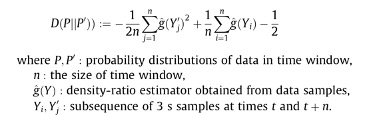

밀도비를 기반으로 불일치도 계산하는 코드: 병렬처리로 효율적으로 계산한다.

In [19]:
!pip install densratio #두개의 데이터 세트. 즉 연속된 time window에서 밀도비 추정
!pip install ray #분산처리와 병렬 처리를 위한 라이브러리
!pip install parmap #별렬 처리를 위한 매핑 함수제공


import numpy as np
from scipy.stats import norm
from densratio import densratio
import ray
import parmap
import multiprocessing

np.random.seed(1)

os.environ['RAY_DISABLE_MEMORY_MONITOR'] = '1'

# 불일치도
# 위의 D(P||P') 수식 함수화
@ray.remote
def dissimmirality(x,y,n,obj):
    return 1/(2*n)*(obj.compute_density_ratio(y)**2).sum()+\
        (1/n)*obj.compute_density_ratio(x).sum()-\
            1./2

# obj.compute_density_ratio(y)**2): density- ratio: 밀도비

# 앞뒤 15초 간 데이터 밀도 비 차이를 기반으로 불일치도 계산
@ray.remote
def function(i,data):
    x = data[i:i+15] # 앞 15초
    y = data[i+15:i+30] # 뒤 15초
    densratio_obj = densratio(x, y, alpha=0,verbose=False) 
    # i 기준 앞 15초 time window와 뒤 15초 time window 밀도 비 계산
    dissim = dissimmirality.remote(x,y,15,densratio_obj) # 불일치도 계산
    return dissim

In [25]:
start = time.time()

data = df[['velocity(km/h)','acceleration','yaw_rate']].astype(float).values[1:]

input_list = range(len(data)-30)
result = ray.get([function.remote(i,data) for i in input_list]) # 불일치도 계산
result = [ray.get(i) for i in result]+[0]*15 # 처음 15초와 끝 15초는 불일치도 0

eval_result = result

end = time.time()
print(f"{int((end-start)/60)}분")

(function pid=36526) /Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/densratio/RuLSIF.py:118: RuntimeWarning: divide by zero encountered in log
(function pid=36526)   divergence = log(g_x).sum(axis=0) / n
(function pid=36525) /Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/densratio/RuLSIF.py:118: RuntimeWarning: divide by zero encountered in log
(function pid=36525)   divergence = log(g_x).sum(axis=0) / n
(function pid=36529) /Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/densratio/RuLSIF.py:118: RuntimeWarning: divide by zero encountered in log
(function pid=36529)   divergence = log(g_x).sum(axis=0) / n
(function pid=36532) /Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/densratio/RuLSIF.py:118: RuntimeWarning: divide by zero encountered in log
(function pid=36532)   divergence = log(g_x).sum(axis=0) / n
(function pid=36527) /Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/densratio/RuLSIF.py:118: RuntimeWarning: divide by 

(scheduler +2m52s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +2m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +3m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) Spilled 8203 MiB, 17915 objects, write throughput 350 MiB/s.


(scheduler +11m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
13분


#### (3) 불일치도 데이터 생성

In [26]:
result = eval_result.copy()
len(result)

19984

In [27]:
# 초기값(None) + 첫 15초 간 불일치도 값(None) : 1 + 15개
zero_df = pd.DataFrame({'dissim' : [0 for i in range(1+15)]})

# 불일치도 값 + 끝 15초 간 불일치도 값(None)
result_df = pd.DataFrame({'dissim' : result})
# result_df.to_csv('result_df.csv')

# 전체 불일치도 df 생성
dissim_df = pd.concat([zero_df, result_df], ignore_index = True)

In [29]:
# 불일치도(dissim) df 삽입
new_df = df.copy()
new_df = pd.concat([new_df, dissim_df], axis=1)
new_df.head(20)

daily_dist total_dist      event_date velocity(km/h)   RPM break_on   
0        0000    0141343  21070107204200            000  0000        0  \
1        0000    0141343  21070107204300            000  0000        0   
2        0000    0141343  21070107204400            000  0240        0   
3        0000    0141343  21070107204500            000  0691        0   
4        0000    0141343  21070107204600            000  0615        0   
5        0000    0141343  21070107204700            000  0525        0   
6        0000    0141343  21070107204800            000  0511        0   
7        0000    0141343  21070107204900            000  0527        0   
8        0000    0141343  21070107205000            000  0535        0   
9        0000    0141343  21070107205100            000  0540        0   
10       0000    0141343  21070107205200            000  0543        0   
11       0000    0141343  21070107205300            000  0516        0   
12       0000    0141343  21070107205400            000  0544        0   
13       0000    0141343  21070107205500            000  0535        0   
14       0000    0141343  21070107205600            000  0531        0   
15       0000    0141343  21070107205700            000  0535        0   
16       0000    0141343  21070107205800            000  0543        0   
17       0000    0141343  21070107205900            000  0546        0   
18       0000    0141343  21070107210000            000  0549        0   
19       0000    0141343  21070107210100            000  0556        0   

          lat        lon angle   acc_x   acc_y status yaw_rate acceleration   
0   000000000  000000000   000  -000.0  -001.0     11     None         None  \
1   000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
2   000000000  000000000   000  -000.0  -001.6     11      0.0          0.0   
3   000000000  000000000   000  +000.0  -001.3     11      0.0          0.0   
4   000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   
5   000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   
6   000000000  000000000   000  +000.0  -001.3     11      0.0          0.0   
7   000000000  000000000   000  +000.0  -001.1     11      0.0          0.0   
8   000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   
9   000000000  000000000   000  -000.0  -001.1     11      0.0          0.0   
10  000000000  000000000   000  +000.0  -001.1     11      0.0          0.0   
11  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
12  000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   
13  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
14  000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   
15  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
16  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
17  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
18  000000000  000000000   000  -000.0  -000.8     11      0.0          0.0   
19  000000000  000000000   000  -000.0  -001.0     11      0.0          0.0   

      dissim  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.000000  
8   0.000000  
9   0.000000  
10  0.000000  
11  0.000000  
12  0.000000  
13  0.000000  
14  0.000000  
15  0.000000  
16  0.999867  
17  0.999867  
18  0.999867  
19  0.999867

속도, 가속도, 요레이트, 불일치도 그래프

[]

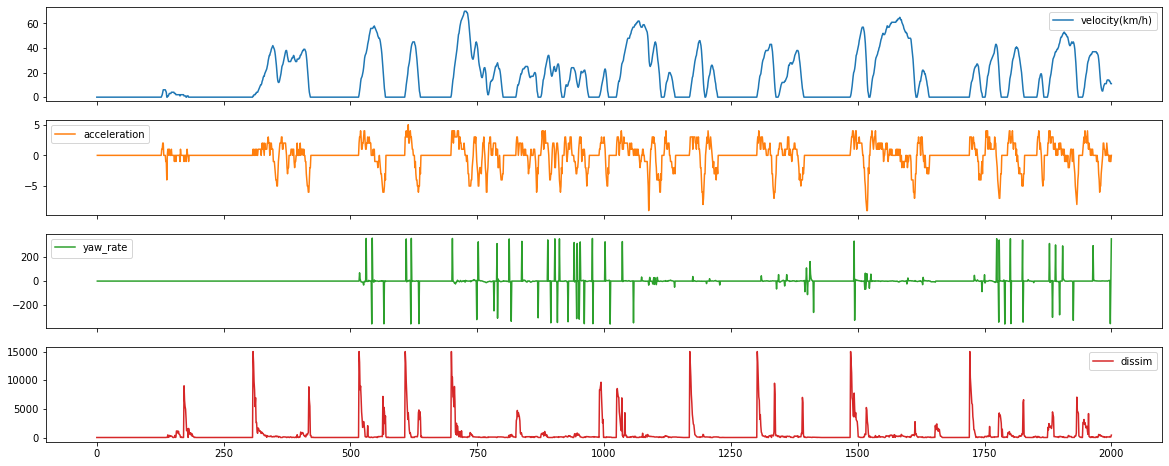

In [31]:
df_sample = new_df.loc[:2000]
df_sample[['velocity(km/h)','acceleration','yaw_rate','dissim']].astype(float).plot(subplots=True, figsize=(20, 8))
plt.legend(loc='best')
plt.plot()

#### (4) 급격한 주행 변화의 시발점 추출
- ##### 불일치도 상위 5% 지점

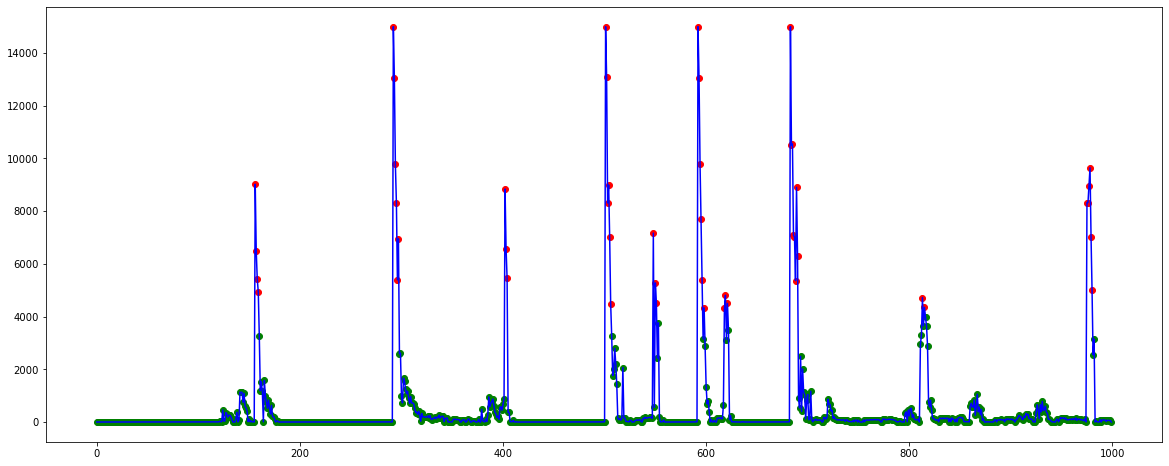

In [32]:
y = np.array(result[:1000])
x = np.arange(len(result[:1000]))

# 임계값 : 상위 5%
threshold = np.quantile(result,0.95)

plt.figure(figsize=(20,8))
plt.plot(x, y, color='blue')

# 임계값을 넘지 않은 값 : green
below_threshold = y < threshold
plt.scatter(x[below_threshold], y[below_threshold], color='green') 

# 임계값을 넘은 값 : red -> 시발점
above_threshold = np.logical_not(below_threshold)
plt.scatter(x[above_threshold], y[above_threshold], color='red')

In [33]:
threshold #4122보다 큰 값은 Driving Event로 정의한다.

4122.899322231049

#### (5) Driving Event 추출
- ##### 15초 간의 위험 운전 데이터
- ##### red point 이후 15초 간 속도, 가속도, 요레이트 데이터

In [34]:
detected = []
for idx in new_df.index:
    if new_df.loc[idx,'dissim']>=threshold:
        values = new_df.loc[idx:idx+14,['velocity(km/h)','acceleration','yaw_rate']].astype(float).values.tolist()
        detected.append(values)

In [37]:
len(new_df)

20000

In [35]:
# 전체 데이터의 5%
driving_event = np.array(detected)
len(driving_event)

1000

In [39]:
# 하나의 Driving Event : 15초 간 속도, 가속도, 요레이트 데이터 (15x3)
# 즉, 한개의 Driving Event에는 56개의 데이터포인트 생성
driving_event[777]

array([[11.,  5.,  0.],
       [14.,  3.,  0.],
       [17.,  3.,  0.],
       [19.,  2.,  0.],
       [20.,  1.,  0.],
       [23.,  3.,  0.],
       [27.,  4.,  0.],
       [31.,  4.,  0.],
       [33.,  2.,  0.],
       [34.,  1.,  0.],
       [35.,  1.,  0.],
       [36.,  1.,  0.],
       [37.,  1.,  0.],
       [36., -1.,  0.],
       [34., -2.,  0.]])

In [40]:
# Driving Event df
data_DE_df = {
    'driving event data(15X3)' : [driving_event[i] for i in range(len(driving_event))],
    'idx' : [j for j in range(len(driving_event))]
}

DE_df = pd.DataFrame(data_DE_df)
DE_df

driving event data(15X3)  idx
0    [[1.0, -1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...    0
1    [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...    1
2    [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, -1.0,...    2
3    [[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0,...    3
4    [[1.0, 1.0, 0.0], [1.0, 0.0, 0.0], [2.0, 1.0, ...    4
..                                                 ...  ...
995  [[9.0, 3.0, 0.0], [13.0, 4.0, 0.0], [15.0, 2.0...  995
996  [[13.0, 4.0, 0.0], [15.0, 2.0, 0.0], [16.0, 1....  996
997  [[15.0, 2.0, 0.0], [16.0, 1.0, 0.0], [18.0, 2....  997
998  [[28.0, 4.0, 0.0], [31.0, 3.0, 0.0], [32.0, 1....  998
999  [[24.0, -7.0, 0.0], [16.0, -8.0, 0.0], [9.0, -...  999

[1000 rows x 2 columns]

---

# Driving Event 차원 축소

### ANN Autoencoder : 입력 데이터의 특징을 추출해 저차원의 latent space로 매핑하는 과정에서 데이터의 차원 축소

#### (1) 모델 생성

In [41]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [42]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self,x):
        self.x = x
    def __getitem__(self,index):
        return torch.from_numpy(self.x[index]).float()
    def __len__(self):
        return len(self.x)

In [43]:
# array -> tensor 변환
dataset = TensorDataset(driving_event)

# train set : validation set = 8 : 2
train_dataset,val_dataset = torch.utils.data.dataset.random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])

# batch size : 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

### Auto Encoder:

비지도 학습 중 하나로, 입력 데이터를 압축하고 재구성하는 과정을 통해 데이터의 특징 추출

Encoder + Decoder

1. Encoder
입력 데이터를 저차원의 표현으로 압축한다. 입력 데이터는 인코더의 입력층에 들어가고, 여러개의 은닉층을 거쳐 최종적으로 저차원의 특징 벡터로 압축된다. 인코더의 목표는 입력 데이터의 주요한 특징을 추출하여 고차원 데이터를 저차원으로 효율적으로 표현하는 것이다.

2. Decoder
디코더는 인코더의 출력인 저차원의 표현을 입력 데이터의 재구성으로 변환. 저차원의 특징 벡터를 받아들이고, 여러개의 은닉층을 거쳐 최종적으로 원본 입력 데이터와 유사한 형태로 재구성하는 것 이 목표이다.

즉, Auto Encoder를 통해 입력데이터를 효율적으로 압축하고 중요한 특징을 학습해 재구성할 수 있다.

In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, device, input_dim, hidden_dim1, hidden_dim2):
        super(AutoEncoder, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(input_dim,hidden_dim1).to(device)
        # input_dim에서 hidden_dim 1로 선형 변환
        self.enc2 = nn.Linear(hidden_dim1,hidden_dim2).to(device)
        # decoder
        self.dec1 = nn.Linear(hidden_dim2,hidden_dim1).to(device)
        self.dec2 = nn.Linear(hidden_dim1,input_dim).to(device)

    # encode(차원 축소) -> decode(복원) -> 결과 return
    def forward(self, x):
        out = x.view(x.size(0), -1).to(device) # 15X3 -> 45X1  2차원으로 펼치기 위해 view 사용
        out = F.relu(self.enc1(out)).to(device) # 45 -> 64
        # F.relu로 인코더의 첫번째 은닉층 통과
        out = F.sigmoid(self.enc2(out)).to(device) # 64 -> 30
        # F.sigmoid로 인코더의 두번째 은닉층 통과
        out = F.relu(self.dec1(out)).to(device) # 30 -> 64
        # F.relu로 디코더 의 첫번째 은닉층 통과
        out = self.dec2(out).to(device) # 64 -> 45
        out = out.view(x.size()).to(device)
        # 디코더의 두번째 선형변환 후 x의 크기로 reshape
        return out

    # 차원 축소만 실행
    def get_codes(self, x):
        out = x.view(x.size(0), -1).to(device) 
        out = F.relu(self.enc1(out)).to(device)
        out = F.sigmoid(self.enc2(out)).to(device)
        return out

In [45]:
# 손실함수
def sparse_loss(model, x):
    loss = 0
    values = x.view(x.size(0), -1) # 차원 재구성
    model_children = list(model.children())
    model_function  = [F.relu,F.sigmoid,F.relu]
    for i in range(len(model_children))[:-1]:
        values = model_function[i]((model_children[i](values))) # 활성화 함수 적용(ReLU, Sigmoid)
        loss += torch.mean(torch.abs(values))
    return loss

In [46]:
# 학습
def train(model, Loss, optimizer, dataloader, scheduler, p):
    losses = [] #손실값 저장
    for batch_X in dataloader:

        batch_X = batch_X.to(device)
        optimizer.zero_grad() # gradient 초기화        
        
        # forward pass
        model.train()
        outputs = model(batch_X)
        mse_loss = Loss(outputs, batch_X) # 손실함수 : MSE(평균제곱오차) 사용
        l1_loss = sparse_loss(model,batch_X) # 희소손실 : L1 Loss = MAELoss(평균절대오차) 사용
        
        loss = mse_loss+p*l1_loss # p : 희소 가중치 하이퍼파라미터
        # 최종 Loss = MSE + {sparsity loss * sparsity weight}
        
        losses.append(loss.data)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    loss = sum(losses) / len(losses)
    return loss,model

In [47]:
# 검증
def validate(model, Loss, dataloader):
    losses = []
    for batch_X in dataloader:

        batch_X = batch_X.to(device)

        # forward pass
        model.eval()
        outputs = model(batch_X)
        loss = Loss(outputs, batch_X)
        losses.append(loss.data)

    loss = sum(losses) / len(losses)
    return loss,model

In [48]:
# 하이퍼파라미터
epochs = 50000
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu 사용
model = AutoEncoder(device, 45, 64, 30).to(device)

Loss = nn.MSELoss()
patience = 100 # 학습에 진전이 없으면 중단
sparsity_param = 0.1 # 희소 가중치 하이퍼파라미터

l2_weight = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_weight)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 1**epoch)

In [49]:
# best epoch 확인
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_epoch_loss,model = train(model,Loss,optimizer,train_dataloader, scheduler, sparsity_param)
    val_epoch_loss,model = validate(model,Loss,val_dataloader)

    train_losses.append(train_epoch_loss.item())
    val_losses.append(val_epoch_loss.item())
    if epoch%500==0:
        print(f'epoch {epoch} | train loss : {train_epoch_loss:.2f} , val loss : {val_epoch_loss:.2f}')
        print('-'*70)
    if min(val_losses)==val_epoch_loss:
        best_model = model
        best_epoch = epoch
        best_loss = train_epoch_loss,val_epoch_loss
    if epoch>patience and min(val_losses[-patience:])==val_losses[-patience]:
        print(f'best epoch {best_epoch} | train loss : {best_loss[0]:.2f} , val loss : {best_loss[1]:.2f}')
        break

/Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 | train loss : 381.86 , val loss : 433.31
----------------------------------------------------------------------
epoch 500 | train loss : 94.18 , val loss : 207.03
----------------------------------------------------------------------
best epoch 860 | train loss : 53.31 , val loss : 175.27


In [50]:
# 차원 축소 결과 확인
# 15X3 -> 30
best_model.get_codes(list(iter(train_dataloader))[0])[0]

tensor([0.0125, 0.1319, 0.1136, 0.1624, 0.0464, 0.1763, 0.4176, 0.2889, 0.2833,
        0.1270, 0.0400, 0.3358, 0.0951, 0.2455, 0.0947, 0.0311, 0.1004, 0.1004,
        0.3091, 0.4665, 0.1538, 0.2404, 0.0807, 0.1378, 0.0196, 0.0822, 0.2467,
        0.1921, 0.0589, 0.2525], grad_fn=<SelectBackward0>)

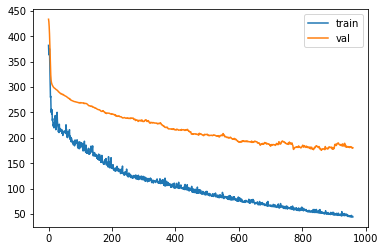

In [51]:
plt.figure(figsize=(6,4))
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.show()

In [39]:
# gpu
torch.cuda.is_available()

True

#### (2) 차원 축소
- ##### 64x15x3 -> 64x30

In [53]:
#batch_size: 한번에 64개의 데이터 샘플을 사용하겠다.
total_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
list(iter(total_dataloader))[0].shape

torch.Size([64, 15, 3])

In [54]:
result1 = []
for batch_X in total_dataloader:
    result1.append(best_model.get_codes(batch_X))

In [55]:
# 64X{30}
print(len(result1))
print(len(result1[0]))
print(len(result1[0][0]))

16
64
30


In [58]:
result2 = []
for x in result1:
    for y in x:
        result2.append(y)

In [59]:
# {30}
print(len(result2))
print(len(result2[0]))

1000
30


In [60]:
# tensor -> array 변환
driving_event_DR = np.array([x.cpu().detach().numpy() for x in result2])
driving_event_DR.shape

(1000, 30)

In [62]:
# 차원축소 전 데이터 (15X3)
driving_event[50]

array([[ 11.,   3.,   0.],
       [ 13.,   2.,   0.],
       [ 13.,   0.,   0.],
       [ 15.,   2.,   0.],
       [ 17.,   2.,   0.],
       [ 20.,   3.,   0.],
       [ 24.,   4.,   0.],
       [ 27.,   3.,   0.],
       [ 28.,   1., 330.],
       [ 29.,   1.,  -4.],
       [ 30.,   1.,   0.],
       [ 33.,   3.,   3.],
       [ 35.,   2.,   2.],
       [ 37.,   2.,   2.],
       [ 39.,   2.,   1.]])

In [63]:
# 차원축소 후 데이터 (30)
driving_event_DR[50]

array([7.8105604e-06, 9.9574667e-01, 9.9992526e-01, 5.5783911e-04,
       9.9062961e-01, 9.9412173e-01, 8.4116861e-02, 9.9972695e-01,
       4.3521943e-03, 9.9925631e-01, 4.4573976e-06, 9.9921918e-01,
       8.2446504e-01, 9.9995196e-01, 6.8348128e-01, 9.9877924e-01,
       1.4374549e-04, 1.7866865e-04, 9.9993360e-01, 9.9990427e-01,
       9.9999976e-01, 5.1145826e-04, 9.9972814e-01, 2.4758573e-03,
       2.3171915e-05, 9.9937844e-01, 9.8974609e-01, 5.1162351e-02,
       9.9262273e-01, 9.9999499e-01], dtype=float32)

In [64]:
# 차원축소 된 Driving Event df
data_changed_DE_df = {
    'driving event data(30)' : [driving_event_DR[i] for i in range(len(driving_event_DR))],
    'idx' : [j for j in range(len(driving_event_DR))]
}

changed_DE_df = pd.DataFrame(data_changed_DE_df)
changed_DE_df

driving event data(30)  idx
0    [0.025240147, 0.023636753, 0.076049544, 0.1114...    0
1    [0.033516213, 0.02536019, 0.076129034, 0.10000...    1
2    [0.02763348, 0.019625628, 0.082707234, 0.10158...    2
3    [0.028723793, 0.015430477, 0.081533715, 0.0987...    3
4    [0.03236895, 0.06829339, 0.073626295, 0.137367...    4
..                                                 ...  ...
995  [0.0035118605, 0.18510419, 0.30769435, 0.08713...  995
996  [0.002351597, 0.20814268, 0.3504886, 0.0795233...  996
997  [0.0019086201, 0.21898328, 0.3981584, 0.070863...  997
998  [0.00024771233, 0.3687939, 0.6309308, 0.048229...  998
999  [0.00061179145, 0.07717872, 0.039348904, 0.546...  999

[1000 rows x 2 columns]

---

# Driving Event 군집화

### K-means Clustering : 데이터를 K개의 군집으로 그룹화하여 비슷한 특성을 가지는 데이터끼리 묶음
### 정돈되지 않은 위험 운전 데이터를 유형 별로 나누고자 군집화 실행
- #### Driving Event 데이터 군집화
- #### 특징이 비슷한 Driving Event끼리 그룹을 이룸

#### (1) 차원축소 된 Driving Event 군집화

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=29), k=(1, 30))

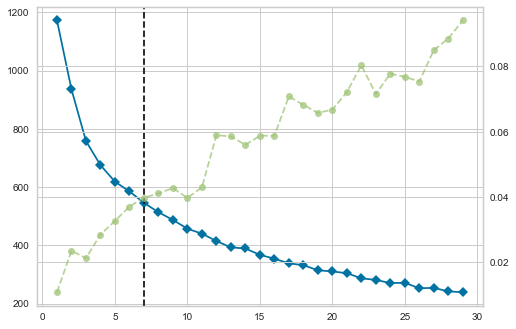

In [69]:
!pip install yellowbrick
!pip install sklearn

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,30))
visualizer.fit(driving_event_DR)

In [70]:
# K
K_elbow = visualizer.elbow_value_
K_elbow

7

In [67]:
# K_value = K_elbow

In [68]:
# 군집 수 임의로 설정
K_value = 8

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(driving_event_DR)

In [72]:
kmeans = KMeans(n_clusters=K_value, init='k-means++', max_iter=300, random_state=10)
kmeans.fit(data_scale)

KMeans(random_state=10)

In [73]:
changed_DE_df['cluster'] = kmeans.labels_
changed_DE_df

driving event data(30)  idx  cluster
0    [0.025240147, 0.023636753, 0.076049544, 0.1114...    0        2
1    [0.033516213, 0.02536019, 0.076129034, 0.10000...    1        2
2    [0.02763348, 0.019625628, 0.082707234, 0.10158...    2        2
3    [0.028723793, 0.015430477, 0.081533715, 0.0987...    3        2
4    [0.03236895, 0.06829339, 0.073626295, 0.137367...    4        2
..                                                 ...  ...      ...
995  [0.0035118605, 0.18510419, 0.30769435, 0.08713...  995        1
996  [0.002351597, 0.20814268, 0.3504886, 0.0795233...  996        1
997  [0.0019086201, 0.21898328, 0.3981584, 0.070863...  997        1
998  [0.00024771233, 0.3687939, 0.6309308, 0.048229...  998        5
999  [0.00061179145, 0.07717872, 0.039348904, 0.546...  999        2

[1000 rows x 3 columns]

#### (2) 각 군집에 해당하는 데이터 인덱스 추출
- ##### 인덱스 이용해 원본 Driving Event에 군집화 적용 가능

In [74]:
cluster_dic = {}
    
for i in range(K_value):
    cluster_dic[f"cluster_{i}"] = list(changed_DE_df.groupby('cluster').get_group(i)['idx'])
    
cluster_dic.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])

In [79]:
cluster_dic['cluster_0']

[28,
 33,
 82,
 84,
 111,
 112,
 113,
 124,
 125,
 126,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 183,
 184,
 185,
 186,
 187,
 188,
 194,
 195,
 196,
 233,
 234,
 235,
 236,
 237,
 298,
 299,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 384,
 385,
 386,
 387,
 388,
 390,
 391,
 392,
 393,
 394,
 407,
 423,
 424,
 426,
 427,
 428,
 429,
 447,
 454,
 455,
 456,
 459,
 460,
 461,
 465,
 466,
 467,
 468,
 469,
 502,
 503,
 504,
 507,
 508,
 509,
 510,
 552,
 553,
 554,
 555,
 556,
 557,
 565,
 566,
 567,
 568,
 569,
 588,
 589,
 590,
 591,
 637,
 638,
 645,
 697,
 698,
 699,
 700,
 701,
 731,
 732,
 733,
 734,
 779,
 792,
 834,
 835,
 836,
 837,
 897,
 923,
 939,
 940,
 941,
 942,
 950,
 951,
 952,
 953,
 963]

In [60]:
# cluster_5 해당하는 인덱스
# cluster_dic['cluster_5']

---

# 평가지표 생성 및 군집 별 점수 정의

### K개의 군집은 K개의 서로 다른 위험 운행 유형을 의미함
### 위험 운행 유형 별 점수를 정의함
- #### 군집화 결과로 나온 군집 별 특징 파악
- #### 기준을 설정하여 평가지표 삽입
- #### 평가지표 기반으로 군집 별 위험도 스코어링

#### (1) 군집 별 특징 확인

In [81]:
cluster_dic.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])

In [82]:
DE_df

driving event data(15X3)  idx
0    [[1.0, -1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0,...    0
1    [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...    1
2    [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, -1.0,...    2
3    [[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0,...    3
4    [[1.0, 1.0, 0.0], [1.0, 0.0, 0.0], [2.0, 1.0, ...    4
..                                                 ...  ...
995  [[9.0, 3.0, 0.0], [13.0, 4.0, 0.0], [15.0, 2.0...  995
996  [[13.0, 4.0, 0.0], [15.0, 2.0, 0.0], [16.0, 1....  996
997  [[15.0, 2.0, 0.0], [16.0, 1.0, 0.0], [18.0, 2....  997
998  [[28.0, 4.0, 0.0], [31.0, 3.0, 0.0], [32.0, 1....  998
999  [[24.0, -7.0, 0.0], [16.0, -8.0, 0.0], [9.0, -...  999

[1000 rows x 2 columns]

In [83]:
clusters_total = pd.DataFrame()

for key in cluster_dic.keys():
    total_df = DE_df.iloc[cluster_dic[key]]
    total_df.reset_index(drop=True, inplace=True)
    
    mean_df = pd.DataFrame(total_df['driving event data(15X3)'].mean(), columns=[['velocity', 'acceleration', 'yaw rate']])

    cluster_df = pd.DataFrame(mean_df.mean())
    cluster_df = cluster_df.transpose()
    
    clusters_total = pd.concat([clusters_total, cluster_df])
    
clusters_total.index = list(cluster_dic.keys())

In [85]:
# 전체 클러스터의 속도, 가속도, 요레이트 평균값
clusters_total = clusters_total.round(2)
clusters_total

velocity acceleration yaw rate
cluster_0    16.96         0.36     0.05
cluster_1    21.93         1.88     0.26
cluster_2     5.46        -0.38     0.16
cluster_3    21.74         1.33    12.88
cluster_4    21.27         1.88    21.35
cluster_5    41.78         0.56     0.32
cluster_6    12.25        -0.30   -21.30
cluster_7    17.53         1.19    14.41

#### (2) 평가지표 삽입
- ##### Velocity Evalution : Low/Mid/High: quantile 0.66, 0.33 기준
- ##### Acceleration Safety : safety/danger: Velocity의 Low, Mid, High 별 ACC 고려 
- ##### Steering Safety : safety/danger: Velocity의 Low, Mid, High 별 Yaw 고려 

In [87]:
clusters_eval = clusters_total.copy()

In [88]:
# 속도
h_val = clusters_eval['velocity'].quantile(q=0.66).values[0].round(2)
m_val = clusters_eval['velocity'].quantile(q=0.33).values[0].round(2)
print(f"[level] velocity_evaluation \nHigh : {h_val} 이상\n\
Mid : {m_val} 이상 | {h_val} 이하\n\
Low : {m_val} 이하")

[level] velocity_evaluation 
High : 21.56 이상
Mid : 17.14 이상 | 21.56 이하
Low : 17.14 이하


In [89]:
condition_ls = [
    (clusters_eval['velocity'] >= h_val),
    (clusters_eval['velocity'] >= m_val) & (clusters_eval['velocity'] < h_val),
    (clusters_eval['velocity'] < m_val)
]
choice_ls = ['High', 'Mid', 'Low']

clusters_eval['velocity_eval'] = np.select(condition_ls, choice_ls)

In [90]:
# 가속도: 범위별로 나눠서 생각
low_u = clusters_eval['acceleration'].quantile(q=0.85).values[0].round(2)
low_d = clusters_eval['acceleration'].quantile(q=0.15).values[0].round(2)
mid_u = clusters_eval['acceleration'].quantile(q=0.70).values[0].round(2)
mid_d = clusters_eval['acceleration'].quantile(q=0.30).values[0].round(2)
high_u = clusters_eval['acceleration'].quantile(q=0.55).values[0].round(2)
high_d = clusters_eval['acceleration'].quantile(q=0.45).values[0].round(2)
print(f"[danger] acc_safety \nLow : {low_u} 이상  | {low_d} 이하\n\
Mid : {mid_u} 이상  | {mid_d} 이하\n\
High : {high_u} 이상 | {high_d} 이하")

[danger] acc_safety 
Low : 1.85 이상  | -0.27 이하
Mid : 1.32 이상  | 0.38 이하
High : 1.1 이상 | 0.65 이하


In [91]:
clusters_eval['acc_safety'] = clusters_eval.apply(
    lambda x: 'danger' 
    if (
        ((x['velocity_eval'] == 'Low') & ((x['acceleration'] >= low_u) | (x['acceleration'] <= low_d))) |
        ((x['velocity_eval'] == 'Mid') & ((x['acceleration'] >= mid_u) | (x['acceleration'] <= mid_d))) |
        ((x['velocity_eval'] == 'High') & ((x['acceleration'] >= high_u) | (x['acceleration'] <= high_d)))
       )
    else 'safety', axis='columns')

In [92]:
clusters_eval

velocity acceleration yaw rate velocity_eval acc_safety
cluster_0    16.96         0.36     0.05           Low     safety
cluster_1    21.93         1.88     0.26          High     danger
cluster_2     5.46        -0.38     0.16           Low     danger
cluster_3    21.74         1.33    12.88          High     danger
cluster_4    21.27         1.88    21.35           Mid     danger
cluster_5    41.78         0.56     0.32          High     danger
cluster_6    12.25        -0.30   -21.30           Low     danger
cluster_7    17.53         1.19    14.41           Mid     safety

In [93]:
# 요레이트
low_u = clusters_eval['yaw rate'].quantile(q=0.85).values[0].round(2)
low_d = clusters_eval['yaw rate'].quantile(q=0.15).values[0].round(2)
mid_u = clusters_eval['yaw rate'].quantile(q=0.70).values[0].round(2)
mid_d = clusters_eval['yaw rate'].quantile(q=0.30).values[0].round(2)
high_u = clusters_eval['yaw rate'].quantile(q=0.55).values[0].round(2)
high_d = clusters_eval['yaw rate'].quantile(q=0.45).values[0].round(2)
print(f"[danger] steer_safety \nLow : {low_u} 이상  | {low_d} 이하\n\
Mid : {mid_u} 이상  | {mid_d} 이하\n\
High : {high_u} 이상 | {high_d} 이하")

[danger] steer_safety 
Low : 14.33 이상  | 0.06 이하
Mid : 11.62 이상  | 0.17 이하
High : 0.31 이상 | 0.27 이하


In [94]:
clusters_eval['steer_safety'] = clusters_eval.apply(
    lambda x: 'danger' 
    if (
        ((x['velocity_eval'] == 'Low') & ((x['yaw rate'] >= low_u) | (x['yaw rate'] <= low_d))) |
        ((x['velocity_eval'] == 'Mid') & ((x['yaw rate'] >= mid_u) | (x['yaw rate'] <= mid_d))) |
        ((x['velocity_eval'] == 'High') & ((x['yaw rate'] >= high_u) | (x['yaw rate'] <= high_d)))
       )
    else 'safety', axis='columns')

In [95]:
# 평가지표 삽입 결과
clusters_eval

velocity acceleration yaw rate velocity_eval acc_safety steer_safety
cluster_0    16.96         0.36     0.05           Low     safety       danger
cluster_1    21.93         1.88     0.26          High     danger       danger
cluster_2     5.46        -0.38     0.16           Low     danger       safety
cluster_3    21.74         1.33    12.88          High     danger       danger
cluster_4    21.27         1.88    21.35           Mid     danger       danger
cluster_5    41.78         0.56     0.32          High     danger       danger
cluster_6    12.25        -0.30   -21.30           Low     danger       danger
cluster_7    17.53         1.19    14.41           Mid     safety       danger

#### (3) 평가지표 기반 위험도 계산
- ##### Low/Mid/High : 1점, 2점, 3점    
- ##### safety/danger : 1점, 2점

In [96]:
# 속도
condition_ls = [
    (clusters_eval['velocity_eval'] == 'Low'),
    (clusters_eval['velocity_eval'] == 'Mid'),
    (clusters_eval['velocity_eval'] == 'High'),
]
choice_ls = [1, 2, 3]

vel_score = np.select(condition_ls, choice_ls)

In [97]:
# 가속도
condition_ls = [
    (clusters_eval['acc_safety'] == 'safety'),
    (clusters_eval['acc_safety'] == 'danger'),
]
choice_ls = [1, 2]

acc_score = np.select(condition_ls, choice_ls)

In [98]:
# 요레이트
condition_ls = [
    (clusters_eval['steer_safety'] == 'safety'),
    (clusters_eval['steer_safety'] == 'danger'),
]
choice_ls = [1, 2]

steer_score = np.select(condition_ls, choice_ls)

In [99]:
dangerousness = vel_score * acc_score * steer_score
clusters_eval['dangerousness'] = dangerousness

In [100]:
# 위험도 삽입 결과
clusters_eval

velocity acceleration yaw rate velocity_eval acc_safety   
cluster_0    16.96         0.36     0.05           Low     safety  \
cluster_1    21.93         1.88     0.26          High     danger   
cluster_2     5.46        -0.38     0.16           Low     danger   
cluster_3    21.74         1.33    12.88          High     danger   
cluster_4    21.27         1.88    21.35           Mid     danger   
cluster_5    41.78         0.56     0.32          High     danger   
cluster_6    12.25        -0.30   -21.30           Low     danger   
cluster_7    17.53         1.19    14.41           Mid     safety   

          steer_safety dangerousness  
cluster_0       danger             2  
cluster_1       danger            12  
cluster_2       safety             2  
cluster_3       danger            12  
cluster_4       danger             8  
cluster_5       danger            12  
cluster_6       danger             4  
cluster_7       danger             4

---

# 추가적인 스코어링

### 엔트로피 가중치

군집 내 데이터가 얼마나 다양한 값을 가지는지 나타내는 엔트로피를 기반으로 한 가중치.

군집 내 엔트로피가 낮을수록, 즉 데이터가 한가지 값에 몰려있을수록 군집이 순수하다.

엔트로피 가중치는 일반적으로 군집 내 엔트로피를 최소화하는 방향으로 간주한다. 즉, 엔트로피 가중치를 이요해 군집 별 스코어링을 진행하면 엔트로피가 낮은 군집에 높은 가중치를 부여해 중요한 군집으로 간주한다.

In [116]:
from scipy.stats import entropy

def compute_entropy_weights(df, feature_cols):
    # 군집 별 엔트로피 계산
    entropy_values = df[feature_cols].apply(lambda x: entropy(x.value_counts(normalize=True)))
    
    # 엔트로피를 확률 분포로 변환
    entropy_prob = entropy_values / entropy_values.sum()
    
    # 엔트로피 가중치 계산
    entropy_weights = 1 - entropy_prob
    
    # 정규화
    normalized_weights = entropy_weights / entropy_weights.sum()
    
    return normalized_weights

# 엔트로피 가중치 계산
feature_cols = ['velocity', 'acceleration', 'yaw rate']
weights = compute_entropy_weights(normal_df, feature_cols)

print(weights)

velocity        0.328571
acceleration    0.342857
yaw rate        0.328571
dtype: float64


### 엔트로피 가중치 이용한 군집 별 스코어링

In [102]:
df = clusters_eval.copy()

df = df[['velocity', 'acceleration', 'yaw rate']]
df[df < 0] = -df
df

velocity acceleration yaw rate
cluster_0    16.96         0.36     0.05
cluster_1    21.93         1.88     0.26
cluster_2     5.46         0.38     0.16
cluster_3    21.74         1.33    12.88
cluster_4    21.27         1.88    21.35
cluster_5    41.78         0.56     0.32
cluster_6    12.25         0.30    21.30
cluster_7    17.53         1.19    14.41

In [103]:
df.dtypes

velocity        float64
acceleration    float64
yaw rate        float64
dtype: object

In [104]:
# 정규화 및 확률변수로 변환
normal_df = df.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
normal_df = normal_df.apply(lambda x: (x/x.sum()), axis=0)
normal_df

velocity acceleration  yaw rate
cluster_0  0.099792     0.010949  0.000000
cluster_1  0.142919     0.288321  0.002986
cluster_2  0.000000     0.014599  0.001564
cluster_3  0.141270     0.187956  0.182426
cluster_4  0.137192     0.288321  0.302858
cluster_5  0.315168     0.047445  0.003839
cluster_6  0.058921     0.000000  0.302147
cluster_7  0.104738     0.162409  0.204180

In [105]:
# 엔트로피
entropy_df = normal_df.apply(lambda x: ((x*np.log2(x)).sum())/(-np.log2(2000)), axis=0)
entropy_df

/Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


velocity        0.239983
acceleration    0.208172
yaw rate        0.185106
dtype: float64

In [106]:
# 다양성의 정도
diversity_df = 1 - entropy_df
diversity_df

velocity        0.760017
acceleration    0.791828
yaw rate        0.814894
dtype: float64

In [107]:
# 가중치
weigth = {'vel_weigth' : diversity_df['velocity'] / diversity_df.sum(),
          'acc_weigth' : diversity_df['acceleration'] / diversity_df.sum(),
          'yaw_weigth' : diversity_df['yaw rate'] / diversity_df.sum()}

In [108]:
sum(weigth.values())

1.0

In [110]:
weigth

{'vel_weigth': 0.3211240333963715,
 'acc_weigth': 0.33456517324089724,
 'yaw_weigth': 0.3443107933627313}

In [117]:
score = df['velocity'].values * weigth['vel_weigth'] +\
        df['acceleration'].values * weigth['acc_weigth'] +\
        df['yaw rate'].values * weigth['yaw_weigth']

score = score.round(2)

In [118]:
df['score(entropy)'] = score

In [119]:
clusters_eval_entropy = df.copy()
clusters_eval_entropy

velocity acceleration yaw rate score(entropy)
cluster_0    16.96         0.36     0.05           5.58
cluster_1    21.93         1.88     0.26           7.76
cluster_2     5.46         0.38     0.16           1.94
cluster_3    21.74         1.33    12.88          11.86
cluster_4    21.27         1.88    21.35          14.81
cluster_5    41.78         0.56     0.32          13.71
cluster_6    12.25         0.30    21.30          11.37
cluster_7    17.53         1.19    14.41          10.99

---

# K-means Clustering 시각화

### 군집 간 특징 분석
- #### 각 군집의 평균 속도, 평균 가속도, 평균 요레이트 값 확인

#### (1) Bar Plot

In [120]:
clusters_total

velocity acceleration yaw rate
cluster_0    16.96         0.36     0.05
cluster_1    21.93         1.88     0.26
cluster_2     5.46        -0.38     0.16
cluster_3    21.74         1.33    12.88
cluster_4    21.27         1.88    21.35
cluster_5    41.78         0.56     0.32
cluster_6    12.25        -0.30   -21.30
cluster_7    17.53         1.19    14.41

In [121]:
# 인덱스명, 소수점 수정
for i in range(K_value):
    clusters_total = clusters_total.rename(index = {f'cluster_{i}' : f'{i+1}'})

clusters_total = clusters_total.round(2)
clusters_total

velocity acceleration yaw rate
1    16.96         0.36     0.05
2    21.93         1.88     0.26
3     5.46        -0.38     0.16
4    21.74         1.33    12.88
5    21.27         1.88    21.35
6    41.78         0.56     0.32
7    12.25        -0.30   -21.30
8    17.53         1.19    14.41

In [122]:
vel_values = [i[0] for i in clusters_total['velocity'].values.tolist()]
acc_values = [i[0] for i in clusters_total['acceleration'].values.tolist()]
yaw_values = [i[0] for i in clusters_total['yaw rate'].values.tolist()]

In [124]:
print('vel_values: ', vel_values)
print('acc_values: ', acc_values)
print('yaw_values: ', yaw_values)

vel_values:  [16.96, 21.93, 5.46, 21.74, 21.27, 41.78, 12.25, 17.53]
acc_values:  [0.36, 1.88, -0.38, 1.33, 1.88, 0.56, -0.3, 1.19]
yaw_values:  [0.05, 0.26, 0.16, 12.88, 21.35, 0.32, -21.3, 14.41]


In [125]:
clusters_len = [len(list(cluster_dic.values())[i]) for i in range(K_value)]
clusters_width = [(clusters_len[i] / sum(clusters_len)) * 1.8 for i in range(K_value)]

In [127]:
print(clusters_len)
print(clusters_width)

[123, 519, 260, 26, 5, 53, 7, 7]
[0.2214, 0.9342, 0.468, 0.0468, 0.009000000000000001, 0.0954, 0.0126, 0.0126]


#### 군집 별 속도

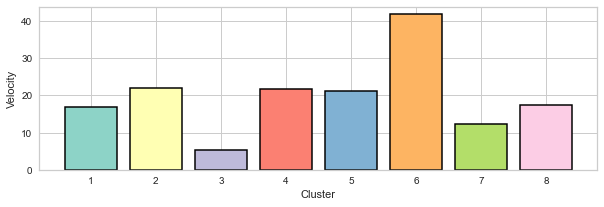

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

x = np.arange(K_value)
clusters = clusters_total.index
values = vel_values
colors = sns.color_palette('Set3', len(x))

plt.figure(figsize=(10,3))
plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.5)
# plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.0, width=clusters_width)

plt.xticks(x, clusters)
plt.xlabel('Cluster')
plt.ylabel('Velocity')

plt.show()

#### 군집 별 가속도

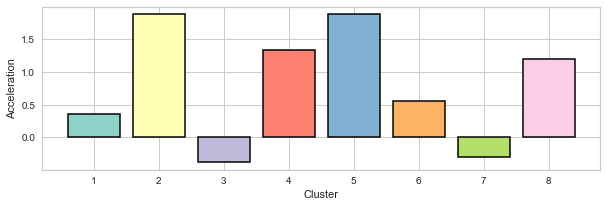

In [129]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(K_value)
clusters = clusters_total.index
values = acc_values
colors = sns.color_palette('Set3', len(x))

plt.figure(figsize=(10,3))
plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.5)
# plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.0, width=clusters_width)

plt.xticks(x, clusters)
plt.xlabel('Cluster')
plt.ylabel('Acceleration')

plt.show()

#### 군집 별 yaw rate

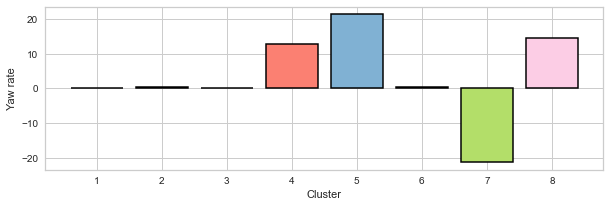

In [130]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(K_value)
clusters = clusters_total.index
values = yaw_values
colors = sns.color_palette('Set3', len(x))

plt.figure(figsize=(10,3))
plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.5)
# plt.bar(x, values, color=colors, edgecolor='black', alpha=1, linewidth=1.0, width=clusters_width)

plt.xticks(x, clusters)
plt.xlabel('Cluster')
plt.ylabel('Yaw rate')

plt.show()

#### (2) Scatter Plot

- ##### 군집의 분포

/Users/jihyeonbin/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:1053: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


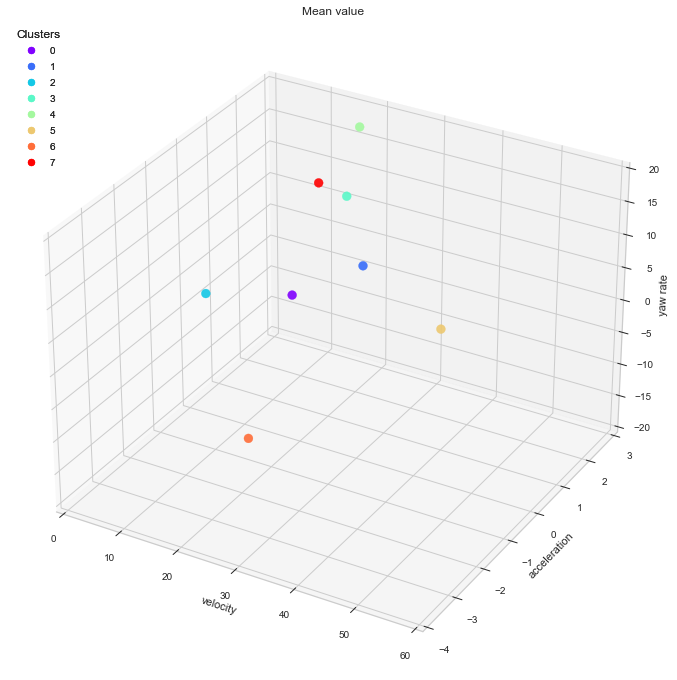

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

x = clusters_total['velocity']
y = clusters_total['acceleration']
z = clusters_total['yaw rate']

color = np.arange(len(clusters_total))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, marker='o', s=80, c=color, cmap='rainbow', alpha=0.9)

legend1 = ax.legend(*scatter.legend_elements(num=color),
                   loc="upper left", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('velocity')
ax.set_ylabel('acceleration')
ax.set_zlabel('yaw rate')

ax.set_xlim(0, 60)
ax.set_ylim(-4, 3)
ax.set_zlim(-20, 20)


plt.title("Mean value")
plt.show()

- ##### 각 군집에 해당하는 데이터의 분포

In [132]:
col1 = [DE_df['driving event data(15X3)'][i][:,0].mean() for i in range(len(DE_df))]
col2 = [DE_df['driving event data(15X3)'][i][:,1].mean() for i in range(len(DE_df))]
col3 = [DE_df['driving event data(15X3)'][i][:,2].mean() for i in range(len(DE_df))]

In [133]:
DE_df_2 = pd.DataFrame({'velocity(avg)' : col1, 'acceleration(avg)' : col2, 'yaw rate(avg)' : col3})
DE_df_2['idx'] = DE_df['idx']
DE_df_2

velocity(avg)  acceleration(avg)  yaw rate(avg)  idx
0         0.466667          -0.133333            0.0    0
1         0.400000          -0.066667            0.0    1
2         0.333333          -0.066667            0.0    2
3         0.266667          -0.066667            0.0    3
4         4.066667           0.600000            0.0    4
..             ...                ...            ...  ...
995      26.600000           2.466667            0.0  995
996      29.066667           2.466667            0.0  996
997      31.400000           2.333333            0.0  997
998      43.200000           2.133333            0.0  998
999      13.066667          -0.266667            0.0  999

[1000 rows x 4 columns]

In [134]:
clusters_3D = pd.DataFrame()
cluster_num = 0

for key in cluster_dic.keys():
    total_df = DE_df_2.iloc[cluster_dic[key]]
    total_df.reset_index(drop=True, inplace=True)
    total_df['cluster'] = cluster_num
    cluster_num += 1
    
    clusters_3D = pd.concat([clusters_3D, total_df], ignore_index=True)
    
clusters_3D

<ipython-input-134-85b33db1d4e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['cluster'] = cluster_num
<ipython-input-134-85b33db1d4e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['cluster'] = cluster_num
<ipython-input-134-85b33db1d4e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

velocity(avg)  acceleration(avg)  yaw rate(avg)  idx  cluster
0         2.200000          -1.400000     -23.600000   28        0
1        33.133333           3.266667      17.866667   33        0
2        21.533333           1.066667       5.933333   82        0
3        22.466667           0.333333       5.800000   84        0
4        10.066667           0.600000       0.000000  111        0
..             ...                ...            ...  ...      ...
995      26.733333           2.000000      22.533333   51        7
996       0.466667          -0.466667       5.666667   68        7
997      20.933333           2.600000       3.933333   69        7
998      14.000000           1.466667       0.000000   94        7
999      27.800000           2.133333      21.666667  103        7

[1000 rows x 5 columns]

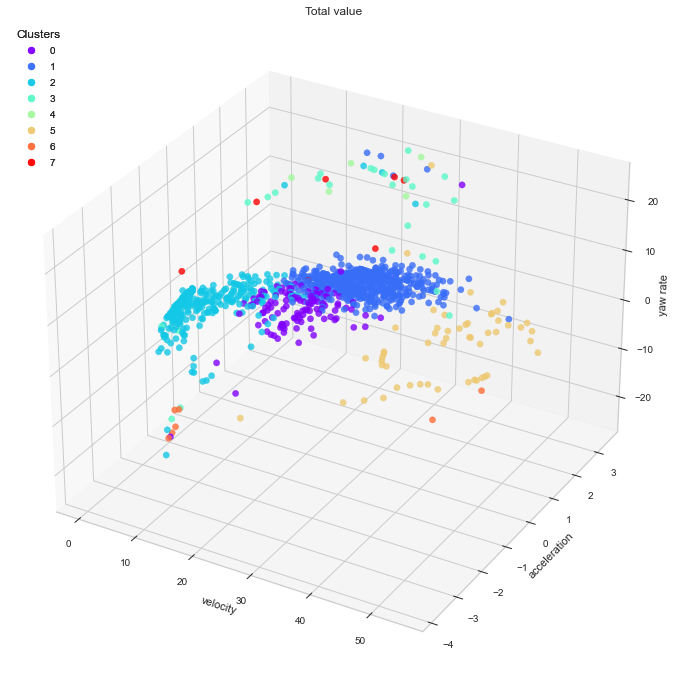

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

x = clusters_3D['velocity(avg)']
y = clusters_3D['acceleration(avg)']
z = clusters_3D['yaw rate(avg)']

color = clusters_3D['cluster']

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, marker='o', alpha=0.8, s=40, cmap='rainbow', c=color) # cmap : Set3/tab20/hsv

legend1 = ax.legend(*scatter.legend_elements(num=len(color.value_counts().sort_index())),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('velocity')
ax.set_ylabel('acceleration')
ax.set_zlabel('yaw rate')

plt.title("Total value")
plt.show()

- ##### 사이즈 축소

In [136]:
# 8~12
threshold = 5

In [137]:
clusters_3D_2 = clusters_3D

In [138]:
import math

for i in range(len(clusters_3D)):
    C = int(clusters_3D.iloc[i]['cluster'])
    V, A, Y = clusters_3D[clusters_3D['cluster'] == C][['velocity(avg)', 'acceleration(avg)', 'yaw rate(avg)']].mean().values
    
    if (math.sqrt((clusters_3D['velocity(avg)'][i]-V)**2 + \
                  (clusters_3D['acceleration(avg)'][i]-A)**2 + \
                  (clusters_3D['yaw rate(avg)'][i]-Y)**2)) > threshold:
        clusters_3D_2 = clusters_3D_2.drop(i)
        
clusters_3D_2.reset_index(drop=True, inplace=True)

In [139]:
clusters_3D_2

velocity(avg)  acceleration(avg)  yaw rate(avg)  idx  cluster
0        14.866667           0.733333            0.0  137        0
1        15.200000           0.333333            0.0  138        0
2        15.200000           0.000000            0.0  139        0
3        14.800000          -0.400000            0.0  140        0
4        12.133333           0.800000            0.0  141        0
..             ...                ...            ...  ...      ...
643      38.666667           0.866667            0.0  971        5
644      39.133333           0.466667            0.0  972        5
645      41.466667           1.533333            0.0  981        5
646      43.866667           1.066667            0.0  982        5
647      43.200000           2.133333            0.0  998        5

[648 rows x 5 columns]

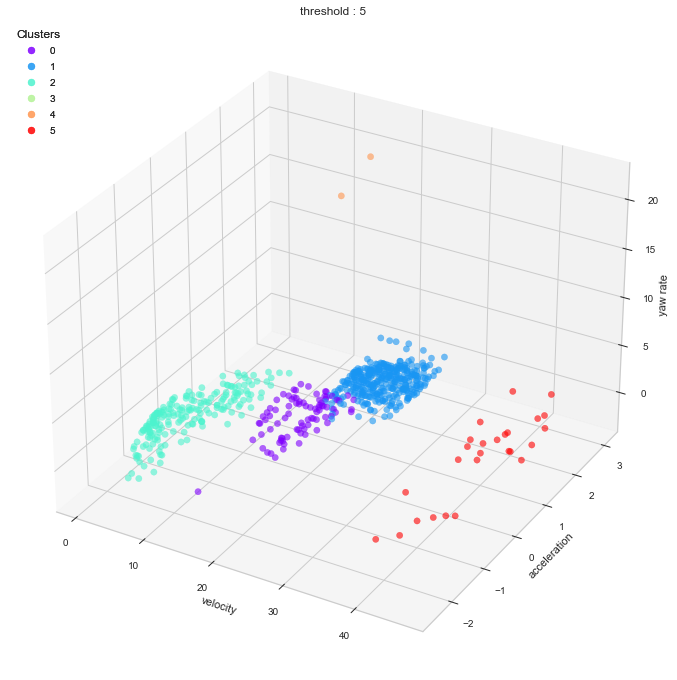

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

x = clusters_3D_2['velocity(avg)']
y = clusters_3D_2['acceleration(avg)']
z = clusters_3D_2['yaw rate(avg)']

color = clusters_3D_2['cluster']

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, marker='o', alpha=0.6, s=40, cmap='rainbow', c=color) # cmap : Set3/tab20/hsv

legend1 = ax.legend(*scatter.legend_elements(num=len(color.value_counts().sort_index())),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)

ax.set_xlabel('velocity')
ax.set_ylabel('acceleration')
ax.set_zlabel('yaw rate')

plt.title(f"threshold : {threshold}")
plt.show()

In [141]:
for i in range(K_value):
    print(f"cluster{i} ")
    print(f"축소 전 : {len(clusters_3D[clusters_3D['cluster']==i])}개")
    print(f"축소 후 : {len(clusters_3D_2[clusters_3D_2['cluster']==i])}개\n")

cluster0 
축소 전 : 123개
축소 후 : 86개

cluster1 
축소 전 : 519개
축소 후 : 337개

cluster2 
축소 전 : 260개
축소 후 : 197개

cluster3 
축소 전 : 26개
축소 후 : 0개

cluster4 
축소 전 : 5개
축소 후 : 2개

cluster5 
축소 전 : 53개
축소 후 : 26개

cluster6 
축소 전 : 7개
축소 후 : 0개

cluster7 
축소 전 : 7개
축소 후 : 0개



---

# 운전자 평가

- ### 새로운 운전자의 DTG 데이터로 Driving Event 추출
- ### 생성해놓은 군집화 결과(평가지표) 활용한 운전자 평가

#### (1) 데이터 전처리

In [114]:
input_file = open(dir_+'20210701_░ц▒т71╣┘1116.TXT','r', encoding='cp949')
data = input_file.read()

In [115]:
print(f"file info :\n{data[:76]}")

file info :
############ODR-1200KMJTA18EPBC01009811경기71바11161238100831######Not_00000000


In [116]:
row = int((len(data)-76)/68)
print(f"row :\n{row}")

row :
44630


In [117]:
# df 구성
df = pd.DataFrame(columns=['daily_dist','total_dist','event_date','velocity(km/h)',
                           'RPM','break_on','lat','lon','angle','acc_x','acc_y','status'])
i=0
while True:
    line = data[76+i*68:144+i*68]
    if line=='':break
    df.loc[i]=[line[:4],line[4:11],line[11:25],line[25:28],line[28:32],
               line[32:33],line[33:42],line[42:51],line[51:54],line[54:60],line[60:66],line[66:68]]
    i+=1
    if i%40000==0:break

In [118]:
# dtype 변경
for i in df.index:
    try:df.loc[i,['velocity(km/h)','RPM','angle','acc_x','acc_y']].astype(float)
    except:df.loc[i]=(df.loc[i-1].astype(float)+df.loc[i+1].astype(float))/2

#### (2) 불일치도 계산

In [119]:
# 요레이트, 가속도 컬럼 생성
df['yaw_rate'] = None
df['acceleration'] = None
for idx1,idx2 in zip(df.index[:-1],df.index[1:]):
    yaw1,vel1 = df.loc[idx1,['angle','velocity(km/h)']]
    yaw2,vel2 = df.loc[idx2,['angle','velocity(km/h)']]
    df.loc[idx2,'yaw_rate'] = float(yaw2)-float(yaw1)
    df.loc[idx2,'acceleration'] = float(vel2)-float(vel1)

In [120]:
# 불일치도 계산(10분)
start = time()

np.random.seed(1)

data = df[['velocity(km/h)','acceleration','yaw_rate']].astype(float).values[1:]

input_list = range(len(data)-30)
result = ray.get([function.remote(i,data) for i in input_list])
result = [ray.get(i) for i in result]+[0]*15

end = time()
print(f"{int((end-start)/60)}분")

22분


In [121]:
zero_df = pd.DataFrame({'dissim' : [0 for i in range(1+15)]})
result_df = pd.DataFrame({'dissim' : result})
dissim_df = pd.concat([zero_df, result_df], ignore_index = True)

In [122]:
# 불일치도 df 삽입
new_df = df.copy()
new_df = pd.concat([new_df, dissim_df], axis=1)
new_df.head()

daily_dist total_dist      event_date velocity(km/h)   RPM break_on  \
0       0000    0191903  21070104392100            000  0680        1   
1       0000    0191903  21070104392200            000  0660        1   
2       0000    0191903  21070104392300            000  0680        1   
3       0000    0191903  21070104392400            000  0660        1   
4       0000    0191903  21070104392500            000  0680        1   

         lat        lon angle   acc_x   acc_y status yaw_rate acceleration  \
0  126896076  037420969   000  +008.6  -001.6     00     None         None   
1  126896076  037420969   000  +008.7  -001.9     00      0.0          0.0   
2  126896076  037420969   000  +008.3  -001.7     00      0.0          0.0   
3  126896076  037420969   000  +008.6  -001.6     00      0.0          0.0   
4  126896076  037420969   000  +008.4  -001.5     00      0.0          0.0   

   dissim  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

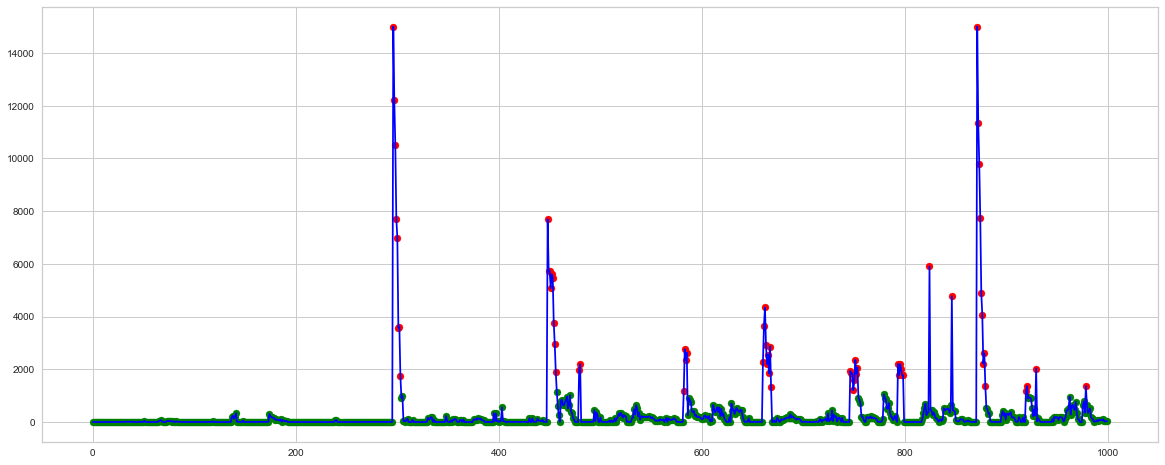

In [123]:
# 0~1000초 간 driving event 발생 지점
y = np.array(result[:1000])
x = np.arange(len(result[:1000]))
threshold = np.quantile(result,0.95)

plt.figure(figsize=(20,8))
plt.plot(x, y, color='blue')

below_threshold = y < threshold
plt.scatter(x[below_threshold], y[below_threshold], color='green') 

above_threshold = np.logical_not(below_threshold)
plt.scatter(x[above_threshold], y[above_threshold], color='red')

In [124]:
threshold

1155.578377997485

#### (3) Driving Event 추출

In [125]:
# driving event
detected = []
for idx in new_df.index:
    if new_df.loc[idx,'dissim']>=threshold:
        values = new_df.loc[idx:idx+14,['velocity(km/h)','acceleration','yaw_rate']].astype(float).values.tolist()
        detected.append(values)

In [126]:
# 전체 데이터의 5%
driving_event = np.array(detected)
len(driving_event)

2000

#### (4) Driving Event 차원 축소

In [127]:
# 차원축소
dataset = TensorDataset(driving_event)
train_dataset,val_dataset = torch.utils.data.dataset.random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [128]:
epochs = 50000
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(device, 45, 64, 30).to(device)

Loss = nn.MSELoss()
patience = 100
sparsity_param = 0.1

l2_weight = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_weight)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 1**epoch)

In [129]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_epoch_loss,model = train(model,Loss,optimizer,train_dataloader, scheduler, sparsity_param)
    val_epoch_loss,model = validate(model,Loss,val_dataloader)

    train_losses.append(train_epoch_loss.item())
    val_losses.append(val_epoch_loss.item())
    if epoch%500==0:
        print(f'epoch {epoch} | train loss : {train_epoch_loss:.2f} , val loss : {val_epoch_loss:.2f}')
        print('-'*70)
    if min(val_losses)==val_epoch_loss:
        best_model = model
        best_epoch = epoch
        best_loss = train_epoch_loss,val_epoch_loss
    if epoch>patience and min(val_losses[-patience:])==val_losses[-patience]:
        print(f'best epoch {best_epoch} | train loss : {best_loss[0]:.2f} , val loss : {best_loss[1]:.2f}')
        break

C:\Users\tactics\anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 | train loss : 1123.12 , val loss : 1090.77
----------------------------------------------------------------------
epoch 500 | train loss : 45.64 , val loss : 120.77
----------------------------------------------------------------------
epoch 1000 | train loss : 12.86 , val loss : 51.69
----------------------------------------------------------------------
epoch 1500 | train loss : 9.42 , val loss : 37.92
----------------------------------------------------------------------
best epoch 1757 | train loss : 8.19 , val loss : 33.53


In [130]:
# 차원 축소 결과 확인
# 15X3 => 30
best_model.get_codes(list(iter(train_dataloader))[0])[0]

tensor([0.3300, 0.2228, 0.2528, 0.3803, 0.2016, 0.2635, 0.3698, 0.6722, 0.4628,
        0.4116, 0.2415, 0.2206, 0.2395, 0.3223, 0.2461, 0.2302, 0.4602, 0.1480,
        0.6702, 0.3450, 0.2461, 0.2315, 0.4620, 0.2427, 0.1745, 0.3813, 0.1845,
        0.3735, 0.3729, 0.2352], device='cuda:0', grad_fn=<SelectBackward0>)

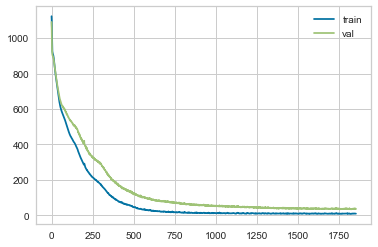

In [131]:
# 모델 수렴
plt.figure(figsize=(6,4))
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.show()

In [132]:
# 전체 driving event 차원 축소
total_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
list(iter(total_dataloader))[0].shape

torch.Size([64, 15, 3])

In [133]:
result1 = []
for batch_X in total_dataloader:
    result1.append(best_model.get_codes(batch_X))

In [134]:
result2 = []
for x in result1:
    for y in x:
        result2.append(y)

In [135]:
# tensor => array 변환
driving_event_DR = np.array([x.cpu().detach().numpy() for x in result2])
driving_event_DR.shape

(2000, 30)

In [136]:
# 차원축소 전 데이터(15X3)
driving_event[777]

array([[36.,  2., -1.],
       [39.,  3., -1.],
       [40.,  1.,  1.],
       [43.,  3., -2.],
       [45.,  2.,  0.],
       [45.,  0.,  2.],
       [48.,  3.,  3.],
       [48.,  0.,  2.],
       [50.,  2.,  1.],
       [51.,  1.,  3.],
       [52.,  1.,  0.],
       [52.,  0.,  1.],
       [50., -2.,  1.],
       [43., -7.,  1.],
       [36., -7.,  1.]])

In [137]:
# 차원축소 후 데이터(30)
driving_event_DR[777]

array([0.31185776, 0.23795989, 0.31225556, 0.27828825, 0.14712977,
       0.29733709, 0.5594463 , 0.69876677, 0.4412868 , 0.59534454,
       0.232014  , 0.27075732, 0.3004079 , 0.29756886, 0.18327674,
       0.2593693 , 0.44954842, 0.23035689, 0.57471657, 0.4137309 ,
       0.19620758, 0.32990253, 0.47649723, 0.18622905, 0.15132284,
       0.4465934 , 0.15550637, 0.62285376, 0.70246154, 0.20339802],
      dtype=float32)

In [138]:
# 차원 축소 DE 데이터프레임 생성
data_changed_DE_df = {
    'driving event data(30)' : [driving_event_DR[i] for i in range(len(driving_event_DR))],
    'idx' : [j for j in range(len(driving_event_DR))]
}

new_df = pd.DataFrame(data_changed_DE_df)
new_df

driving event data(30)   idx
0     [0.55176085, 0.22684215, 0.19949894, 0.5260462...     0
1     [0.17886272, 0.22709194, 0.2576584, 0.24553958...     1
2     [0.20930845, 0.26476344, 0.2286287, 0.25313747...     2
3     [0.22364601, 0.21144593, 0.26850682, 0.2266824...     3
4     [0.22302528, 0.20463319, 0.3599701, 0.2018732,...     4
...                                                 ...   ...
1995  [0.18575734, 0.24405098, 0.32672888, 0.2518492...  1995
1996  [0.26295996, 0.24562055, 0.2785515, 0.2908173,...  1996
1997  [0.15763088, 0.97347283, 0.13190183, 0.7773769...  1997
1998  [0.0190315, 0.03759514, 0.5773468, 0.44478807,...  1998
1999  [0.83215535, 0.06336128, 0.4892066, 0.16103894...  1999

[2000 rows x 2 columns]

#### (5) Driving Event 군집화

In [139]:
# K-means predict
new_data_scale = scaler.fit_transform(driving_event_DR)

new_df['cluster'] = kmeans.predict(new_data_scale)
new_df

driving event data(30)   idx  cluster
0     [0.55176085, 0.22684215, 0.19949894, 0.5260462...     0        1
1     [0.17886272, 0.22709194, 0.2576584, 0.24553958...     1        0
2     [0.20930845, 0.26476344, 0.2286287, 0.25313747...     2        0
3     [0.22364601, 0.21144593, 0.26850682, 0.2266824...     3        0
4     [0.22302528, 0.20463319, 0.3599701, 0.2018732,...     4        0
...                                                 ...   ...      ...
1995  [0.18575734, 0.24405098, 0.32672888, 0.2518492...  1995        3
1996  [0.26295996, 0.24562055, 0.2785515, 0.2908173,...  1996        3
1997  [0.15763088, 0.97347283, 0.13190183, 0.7773769...  1997        6
1998  [0.0190315, 0.03759514, 0.5773468, 0.44478807,...  1998        5
1999  [0.83215535, 0.06336128, 0.4892066, 0.16103894...  1999        4

[2000 rows x 3 columns]

In [140]:
cluster_dic = {}
    
for i in range(K_value):
    cluster_dic[f"cluster_{i}"] = list(new_df.groupby('cluster').get_group(i)['idx'])
    
cluster_dic.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'])

In [141]:
# cluster 별 데이터 개수
cluster_data = list(cluster_dic.values())
cluster_num = [len(e) for e in cluster_data]
cluster_num

[129, 55, 37, 1205, 101, 342, 130, 1]

In [142]:
# cluster 별 위험도 점수
cluster_scores = clusters_eval['dangerousness'].values.flatten().tolist()
cluster_scores

[12, 8, 12, 2, 4, 2, 4, 12]

#### (6) Driving Event 기반 운전자 평가
- ##### DRIVER SCORE 1 : 위험도 기반 점수
- ##### DRIVER SCORE 2 : 엔트로피 가중치 기반 점수
- ##### DRIVER BEHAVIOR : 위험 운전의 유형 분석

In [143]:
# 운전자 스코어링_1 : 점수 부여 방식
score_1 = 0
for i in range(K_value):
    score_1 += cluster_scores[i] * cluster_num[i]

print(f"DRIVER SCORE 1 : {score_1}")

DRIVER SCORE 1 : 6462


In [ ]:
# cluster 별 엔트로피 점수
cluster_scores = clusters_eval_entropy['score(entropy)'].values.flatten().tolist()

In [145]:
# 운전자 스코어링_2 : 엔트로피 가중치 방식
score_2 = 0
for i in range(K_value):
    score_2 += cluster_scores[i] * cluster_num[i]

print(f"DRIVER SCORE 2 : {score_2}")

DRIVER SCORE 2 : 7441.33


In [146]:
# 관련성 높은 클러스터
related_cluster = sorted(cluster_dic, key=lambda key:len(cluster_dic[key]), reverse=True)

In [147]:
# 운전자 평가
# 기존 평가지표 df에서 cluster 해당 내용 매칭
print("DRIVER BEHAVIOR : \n")
for cluster in related_cluster[:3]: # 3위까지
    print(pd.DataFrame(clusters_eval.loc[cluster][['velocity_eval', 'acc_safety', 'steer_safety']]))
    print("\n")

DRIVER BEHAVIOR : 

              cluster_3
velocity_eval       Low
acc_safety       danger
steer_safety     safety


              cluster_5
velocity_eval       Low
acc_safety       safety
steer_safety     danger


              cluster_6
velocity_eval       Mid
acc_safety       safety
steer_safety     danger


